In [324]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer

from typing import Dict, Any

In [325]:
test = pd.read_parquet('test')
train = pd.read_parquet('train')

In [326]:
model = LogisticRegression()
one_hot_encoder = OneHotEncoder()
multilabel_binarizer = MultiLabelBinarizer()
count_vectorizer = CountVectorizer(analyzer='word', stop_words='english', max_features=10)

In [327]:
X_FEATURES = [
    'timedelta', 'n_tokens_title', 'n_tokens_content',
    'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
    'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
    'average_token_length', 'num_keywords', 'data_channel_is_lifestyle',
    'data_channel_is_entertainment', 'data_channel_is_bus',
    'data_channel_is_socmed', 'data_channel_is_tech',
    'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
    'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
    'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
    'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
    'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
    'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
    'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
    'global_sentiment_polarity', 'global_rate_positive_words',
    'global_rate_negative_words', 'rate_positive_words',
    'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarity',
    'max_positive_polarity', 'avg_negative_polarity',
    'min_negative_polarity', 'max_negative_polarity', 'title_subjectivity',
    'title_sentiment_polarity', 'abs_title_subjectivity',
    'abs_title_sentiment_polarity', 'content', 'surprise1', 'surprise2',
]

Y_FEATURES = ['popular']

Ordeno por el feature `timedelta`

In [328]:
train = train.sort_values('timedelta', ascending=False)

In [329]:
x_test = test[X_FEATURES]
y_test = test[Y_FEATURES]

Splitteo el set de entrenamiento en $20\%$ `valid` y $80\%$ `train`

In [330]:
x_train, x_valid, y_train, y_valid = train_test_split(train[X_FEATURES], train[Y_FEATURES], test_size=0.2, random_state=10)

def assert_proportion_of_dataset_partition_is(expected_proportion, dataset_to_check, complete_dataset):
    assert(round((len(dataset_to_check) / len(complete_dataset)), 1) == expected_proportion)

assert_proportion_of_dataset_partition_is(expected_proportion=.8, dataset_to_check=x_train, complete_dataset=train[X_FEATURES])
assert_proportion_of_dataset_partition_is(expected_proportion=.2, dataset_to_check=x_valid, complete_dataset=train[X_FEATURES])
assert_proportion_of_dataset_partition_is(expected_proportion=.8, dataset_to_check=y_train, complete_dataset=train[Y_FEATURES])
assert_proportion_of_dataset_partition_is(expected_proportion=.2, dataset_to_check=y_valid, complete_dataset=train[Y_FEATURES])

Me deshago de la feature `timedelta` para no entrenar con ella ya que [por si sola no sirve para predecir ](https://organizacinde-ea47838.slack.com/archives/C02E5FKDTDE/p1654617760733479).

In [331]:
x_train = x_train.drop('timedelta', axis=1)
x_valid = x_valid.drop('timedelta', axis=1)

# Encoding

Encodeo la feature categorica `surprise1` tanto en el `train` set como en el `valid` set.

In [332]:
encoded_surprise1_train = one_hot_encoder.fit_transform(x_train[['surprise1']]).todense().astype(int)
encoded_surprise1_valid = one_hot_encoder.transform(x_valid[['surprise1']]).todense().astype(int)

x_train['surprise1'] = encoded_surprise1_train
x_valid['surprise1'] = encoded_surprise1_valid

Encodeo la feature categorica `surprise2` tanto en el `x_train` set como en el `x_valid` set no sin antes reemplazar los strings vacíos por `"unknown"`.

In [333]:
x_train['surprise2'] = x_train['surprise2'].map(lambda x: 'unknown' if x == '' else x)
x_valid['surprise2'] = x_valid['surprise2'].map(lambda x: 'unknown' if x == '' else x)

encoded_surprise2_train = multilabel_binarizer.fit_transform(x_train['surprise2'])
encoded_surprise2_valid = multilabel_binarizer.transform(x_valid['surprise2'])

x_train['surprise2'] = encoded_surprise2_train
x_valid['surprise2'] = encoded_surprise2_valid

Encodeo la feature categorica `popular` tanto en el `y_train` set como en el `y_valid`.

In [334]:
encoded_y_train = one_hot_encoder.fit_transform(y_train[['popular']]).todense().astype(int)
encoded_y_valid = one_hot_encoder.transform(y_valid[['popular']]).todense().astype(int)
y_train['popular'] = encoded_y_train
y_valid['popular'] = encoded_y_valid

In [335]:
x_train['content'] = x_train['content'].fillna('')
x_valid['content'] = x_valid['content'].fillna('')

vectorized_x_train_content = count_vectorizer.fit_transform(x_train['content'].tolist()).toarray()
x_train_content_word_count = pd.DataFrame(vectorized_x_train_content, columns=count_vectorizer.get_feature_names())

vectorized_x_valid_content = count_vectorizer.transform(x_valid['content'].tolist()).toarray()
x_valid_content_word_count = pd.DataFrame(vectorized_x_valid_content, columns=count_vectorizer.get_feature_names())

x_train['content'] = vectorized_x_train_content
x_valid['content'] = vectorized_x_valid_content

x_train = pd.concat([x_train.reset_index(), x_train_content_word_count.reset_index()], axis=1)
x_valid = pd.concat([x_valid.reset_index(), x_valid_content_word_count.reset_index()], axis=1)

/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [336]:
# x_train = x_train.join(x_train_content_word_count)
# x_valid = x_valid.join(x_valid_content_word_count)

In [337]:
x_train = x_train.fillna(0.0)
x_valid = x_valid.fillna(0.0)

In [338]:
model.fit(x_train, y_train['popular'])

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [339]:
binary_predictions = model.predict(x_valid)
binary_predictions

array([1, 1, 1, ..., 1, 1, 1])

In [340]:
print(classification_report(y_valid['popular'], binary_predictions))

              precision    recall  f1-score   support

           0       0.20      0.03      0.05      1446
           1       0.80      0.97      0.87      5687

    accuracy                           0.78      7133
   macro avg       0.50      0.50      0.46      7133
weighted avg       0.68      0.78      0.71      7133



In [341]:
probability_predictions = model.predict_proba(x_valid)[:,1]
probability_predictions

array([0.77594105, 0.53512458, 0.72858575, ..., 0.78326306, 0.76108965,
       0.82585208])

In [342]:
roc_auc_score(y_valid['popular'], probability_predictions)

0.5921967574976876

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

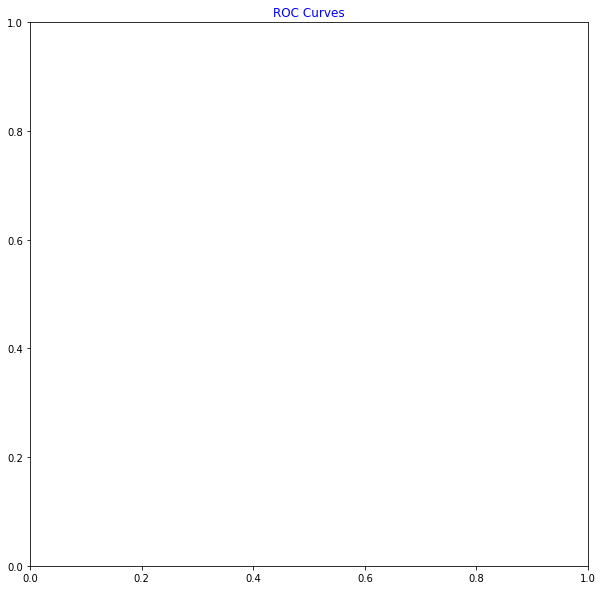

In [343]:
import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_roc(y_valid, probability_predictions, classes_to_plot=1, plot_micro=False, plot_macro=False, figsize=(10,10))
plt.rcParams.update({'text.color': "blue",
                     'axes.labelcolor': "white"})

plt.show()

# Búsqueda de Hiperparámetros